# Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [102]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np

import random

import thinkstats2
import thinkplot
import brfss

## Exercises

**Exercise:** As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use `thinkstats2.SampleRows` to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [95]:
class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()
        
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys
    
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

In [96]:
# Solution

def PTests(live, iters=1000):
   
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansPermute(data)
    p1 = ht.PValue(iters=iters)

    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = DiffMeansPermute(data)
    p2 = ht.PValue(iters=iters)

    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p3 = ht.PValue(iters=iters)

    data = firsts.prglngth.values, others.prglngth.values
    ht = PregLengthTest(data)
    p4 = ht.PValue(iters=iters)
    print("Sample:", "Prglngth p-value:", "BrthWgt p-value:", "Corr age/brthwgt:", "PrgLngh chi test:")
    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (n, p1, p2, p3, p4))

In [99]:
n = len(live)
for _ in range(8):
    sample = thinkstats2.SampleRows(live, n)
    PTests(sample)
    n //= 2

Sample: Prglngth p-value: BrthWgt p-value: Corr age/brthwgt: PrgLngh chi test:
9148	0.18	0.00	0.00	0.00
Sample: Prglngth p-value: BrthWgt p-value: Corr age/brthwgt: PrgLngh chi test:
4574	0.10	0.00	0.00	0.00
Sample: Prglngth p-value: BrthWgt p-value: Corr age/brthwgt: PrgLngh chi test:
2287	0.96	0.01	0.04	0.00
Sample: Prglngth p-value: BrthWgt p-value: Corr age/brthwgt: PrgLngh chi test:
1143	0.39	0.30	0.23	0.00
Sample: Prglngth p-value: BrthWgt p-value: Corr age/brthwgt: PrgLngh chi test:
571	0.24	0.32	0.02	0.63
Sample: Prglngth p-value: BrthWgt p-value: Corr age/brthwgt: PrgLngh chi test:
285	0.28	0.29	0.00	0.73
Sample: Prglngth p-value: BrthWgt p-value: Corr age/brthwgt: PrgLngh chi test:
142	0.67	0.23	0.77	0.00
Sample: Prglngth p-value: BrthWgt p-value: Corr age/brthwgt: PrgLngh chi test:
71	0.73	0.49	0.21	0.92


C:\Users\logan\AppData\Local\Temp/ipykernel_17992/2685863955.py:78: RuntimeWarning: invalid value encountered in true_divide
  stat = sum((observed - expected)**2 / expected)


In [26]:
## range = 8
# Sample: Prglngth p-value: BrthWgt p-value: Corr age/brthwgt: PrgLngh chi test:
# 9148	0.19	0.00	0.00	0.00
# Sample: Prglngth p-value: BrthWgt p-value: Corr age/brthwgt: PrgLngh chi test:
# 4574	0.70	0.00	0.00	0.00
# Sample: Prglngth p-value: BrthWgt p-value: Corr age/brthwgt: PrgLngh chi test:
# 2287	0.97	0.12	0.00	0.00
# Sample: Prglngth p-value: BrthWgt p-value: Corr age/brthwgt: PrgLngh chi test:
# 1143	0.74	0.02	0.00	0.30
# Sample: Prglngth p-value: BrthWgt p-value: Corr age/brthwgt: PrgLngh chi test:
# 571	0.03	0.33	0.04	0.05
# Sample: Prglngth p-value: BrthWgt p-value: Corr age/brthwgt: PrgLngh chi test:
# 285	0.16	0.62	0.75	0.10
# Sample: Prglngth p-value: BrthWgt p-value: Corr age/brthwgt: PrgLngh chi test:
# 142	0.42	0.48	0.00	0.00
# Sample: Prglngth p-value: BrthWgt p-value: Corr age/brthwgt: PrgLngh chi test:
# 71	0.59	0.66	0.26	0.53





## range = 3
# Sample: Prglngth p-value: BrthWgt p-value: Corr age/brthwgt: PrgLngh chi test:
# 9148	0.16	0.00	0.00	0.00
# Sample: Prglngth p-value: BrthWgt p-value: Corr age/brthwgt: PrgLngh chi test:
# 4574	0.31	0.00	0.00	0.00
# Sample: Prglngth p-value: BrthWgt p-value: Corr age/brthwgt: PrgLngh chi test:
# 2287	0.16	0.11	0.00	0.00


# Tests that are positive with large sample sizes generally become negative as sample sizes decrease 
# however some tests still provide positive results at smaller sample sizes.

# Exercises

**Exercise:** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

Read the BRFSS data and extract heights and log weights.

In [106]:
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def LeastSquares(xs, ys):
    meanx, varx = MeanVar(xs)
    meany = Mean(ys)

    slope = Cov(xs, ys, meanx, meany) / varx
    inter = meany - slope * meanx

    return inter, slope

def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys
def Residuals(xs, ys, inter, slope):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    res = ys - (inter + slope * xs)
    return res
def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)

def SampleRows(df, nrows, replace=False):
    """Choose a sample of rows from a DataFrame.

    df: DataFrame
    nrows: number of rows
    replace: whether to sample with replacement

    returns: DataDf
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

def ResampleRows(df):
    """Resamples rows from a DataFrame.

    df: DataFrame

    returns: DataFrame
    """
    return SampleRows(df, len(df), replace=True)
def SamplingDistributions(live, iters=101):
    t = []
    for _ in range(iters):
        sample = ResampleRows(live)
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        estimates = LeastSquares(ages, weights)
        t.append(estimates)

    inters, slopes = zip(*t)
    return inters, slopes
def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = FitLine(xs, inter, slope)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    thinkplot.FillBetween(fxs, low, high, **options)
def CoefDetermination(ys, res):
    return 1 - Var(res) / Var(ys)

class SlopeTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        ages, weights = data
        _, slope = thinkstats2.LeastSquares(ages, weights)
        return slope

    def MakeModel(self):
        _, weights = self.data
        self.ybar = weights.mean()
        self.res = weights - self.ybar

    def RunModel(self):
        ages, _ = self.data
        weights = self.ybar + np.random.permutation(self.res)
        return ages, weights
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

In [104]:
df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3','wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

In [110]:
# Intercept and Slope

inter, slope = thinkstats2.LeastSquares(heights, log_weights)
inter, slope

(0.9930804163917689, 0.005281454169418064)

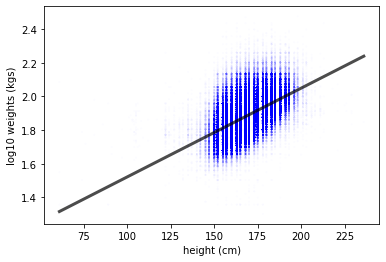

In [112]:
# Scatterplots
thinkplot.Scatter(heights,log_weights,alpha=0.01,s=5)
fxs, fys = thinkstats2.FitLine(heights,inter,slope)
thinkplot.Plot(fxs, fys, color = 'black')
thinkplot.Config(xlabel='height (cm)', ylabel= "log10 weights (kgs)", legend=False)

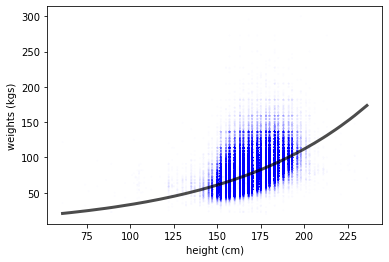

In [121]:
#Scatterplot 2
thinkplot.Scatter(heights, weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, 10**fys, color='black')
thinkplot.Config(xlabel='height (cm)', ylabel='weights (kgs)', legend=False)

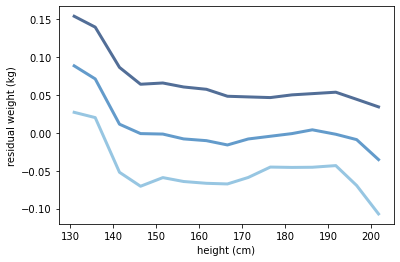

In [122]:
# Residuals Percentiles
resds = thinkstats2.Residuals(heights, log_weights, inter, slope)
df['residual'] = resds

bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(means, ys, label=label)
    
thinkplot.Config(xlabel='height (cm)', ylabel='residual weight (kg)', legend=False)

In [124]:
#Correlation 

corrh=thinkstats2.Corr(heights, log_weights)
corrh

0.5317282605983591

In [126]:
# Coeff of Determination

coeffD=thinkstats2.CoefDetermination(log_weights, resds)
coeffD

0.28273494311894154

In [128]:
#Confirm R^2 = p^2
corrh**2-coeffD

1.4932499681208355e-14

In [132]:
# Computer Std(ys)

std_ys=thinkstats2.Std(log_weights)
std_ys

0.1032072503000493

In [135]:
#computer std(res)

std_resds = thinkstats2.Std(resds)
std_resds

0.08740777080416111

In [137]:
#how much does height info reduce RMSE

1 - std_resds/ std_ys

0.15308497658793496

In [145]:
#use resampling to computer distributions for inter, slope
t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

{'xscale': 'linear', 'yscale': 'linear'}

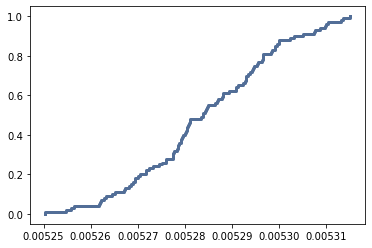

In [146]:
#plot distribution

cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

In [147]:
#pvalue of slope

pvalue = cdf[0]
pvalue

0

In [148]:
#90% CI of slope

ci = cdf.Percentile(5), cdf.Percentile(95)
ci


(0.00526188142477598, 0.005309885185515658)

In [149]:
# mean of distribution

mean = thinkstats2.Mean(slopes)
mean

0.00528448403003027

In [150]:
#std dev/stnd error of distribution

Std_dev = thinkstats2.Std(slopes)
Std_dev

1.4578494115528146e-05

In [153]:
#resample w/o weights, compute mean height and measure

unweighted_sample = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(5)]
Summarize(unweighted_sample)

mean, SE, CI 168.95255007174762 0.011579961762115808 (168.94026758826976, 168.96823905091048)


In [158]:
#resample w/ weights

weighted_sample = [ResampleRowsWeighted(df,'finalwt').htm3.mean() for _ in range(5)]
Summarize(weighted_sample)

mean, SE, CI 170.4883485923321 0.015427486128389071 (170.46144829119424, 170.50587875664422)
